In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np

local_crs = 32636
# path to data
example_data_path = "data"

In [2]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [3]:
HECTARE_IN_SQUARE_METERS = 10_000
gdf = aggregated_blocks[['block_id', 'geometry', 'landuse', 'is_living', 'area', 'current_living_area', 'current_industrial_area', 'current_green_area']]
gdf['free_area'] = (gdf['area']*0.8 - gdf['current_green_area'] - gdf['current_industrial_area'] - gdf['current_living_area'])/HECTARE_IN_SQUARE_METERS

/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet")).rename_geometry('geometry')

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [5]:
from masterplan_tools import CityModel

city_model = CityModel(
  blocks=aggregated_blocks,
  accessibility_matrix=accessibility_matrix,
  services=services
)

/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
all_services = {
    'schools': {250: 1.2, 300: 1.1, 600: 1.3, 800: 1.5, 1100: 1.8},
    'kindergartens': {180: 0.72, 250: 1.44, 280: 1.1},
    'recreational_areas': {100:0.1,500:0.5,1000:1.0,3000:3.0,5000:5.0,10000:10.0,15000:15.0},
    'pharmacies':{1000:0.005, 500:0.0025,1000:0.0050,1500:0.0075},
    'hospitals':{60000:1.5,180000:4.5,272000:6.8,360000:9,600000:15},
    'policlinics':{9615:0.3,19230:0.6,28846:0.8,32692:0.9},
}

scenario = ['hospitals', 'policlinics', 'recreational_areas', 'pharmacies']
weights = None
if not weights:
    weights = [round(1/len(scenario), 2) for i in range(len(scenario))]

scenario = dict(zip(scenario, weights))

In [7]:
scenario

{'hospitals': 0.25,
 'policlinics': 0.25,
 'recreational_areas': 0.25,
 'pharmacies': 0.25}

# Обеспеченность без оптимизации

In [8]:
from masterplan_tools.method.provision import LpProvision
lpp = LpProvision(city_model=city_model)

In [9]:
provisions, mean = lpp.get_scenario_provisions(scenario)
print('Mean provision:', mean)

Mean provision: 0.8644855927569991


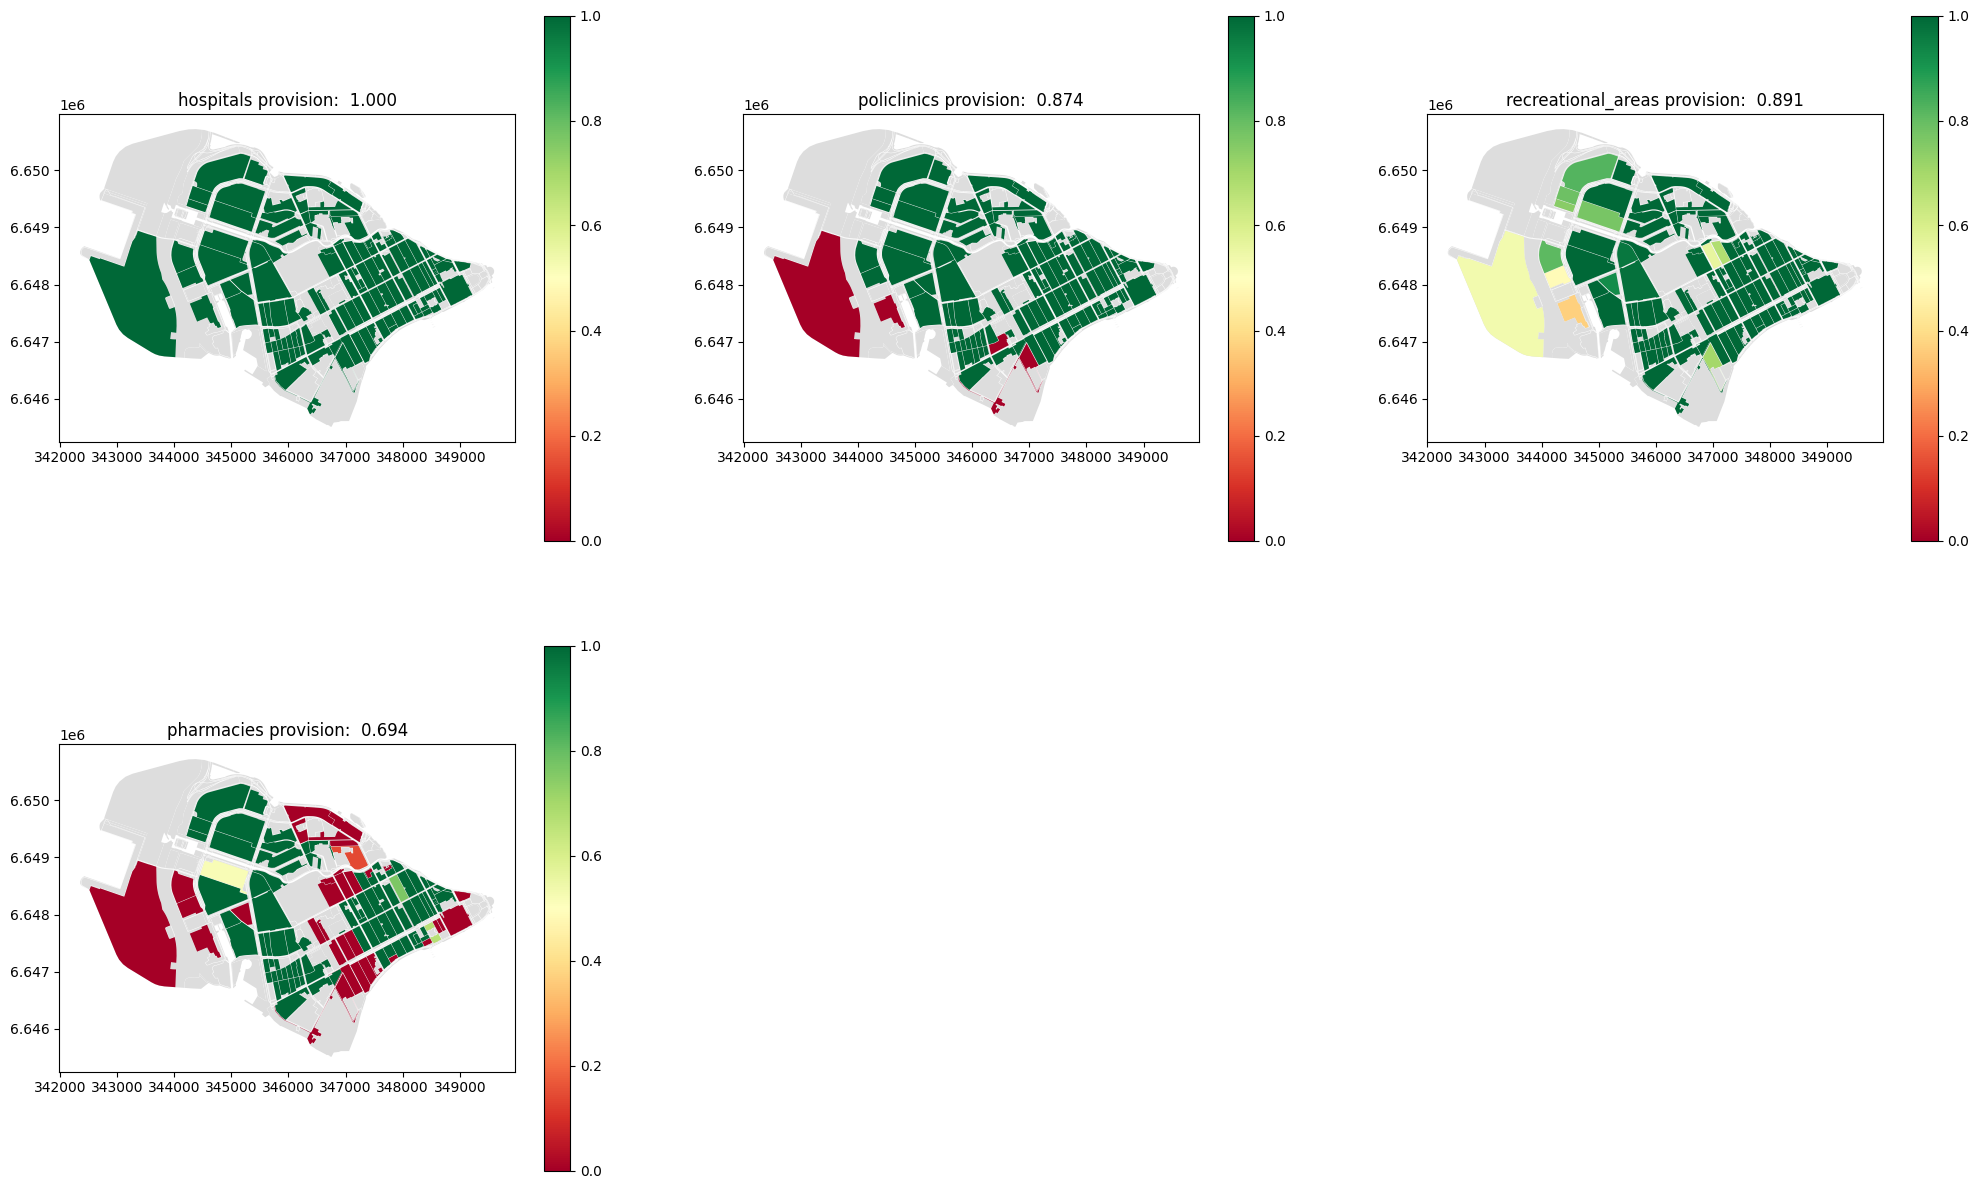

In [10]:
lpp.visualize_provisions(provisions)

# Оптимизация всех кварталов

In [11]:
from masterplan_tools.method.genetic.genetic import Genetic

In [12]:
gen = Genetic(city_model, gdf, all_services, scenario, 3)

In [13]:
ga_params = {
    'num_generations': 10,
    'num_parents_mating': 6,
    'sol_per_pop': 10,
    'mutation_type': 'adaptive',
    'mutation_percent_genes': (90, 10),
    'crossover_type': 'scattered',
    'parent_selection_type': 'tournament',
    'K_tournament': 3,
    'stop_criteria': 'saturate_50',
    'parallel_processing': 12,
    'keep_parents': 1
}

In [14]:
ga_instance, updated_blocks = gen.calculate_blocks_building_optinons(ga_params)

/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
provisions, mean = lpp.get_scenario_provisions(scenario, updated_blocks)
print('Mean provision:', mean)

Mean provision: 0.98756059321356


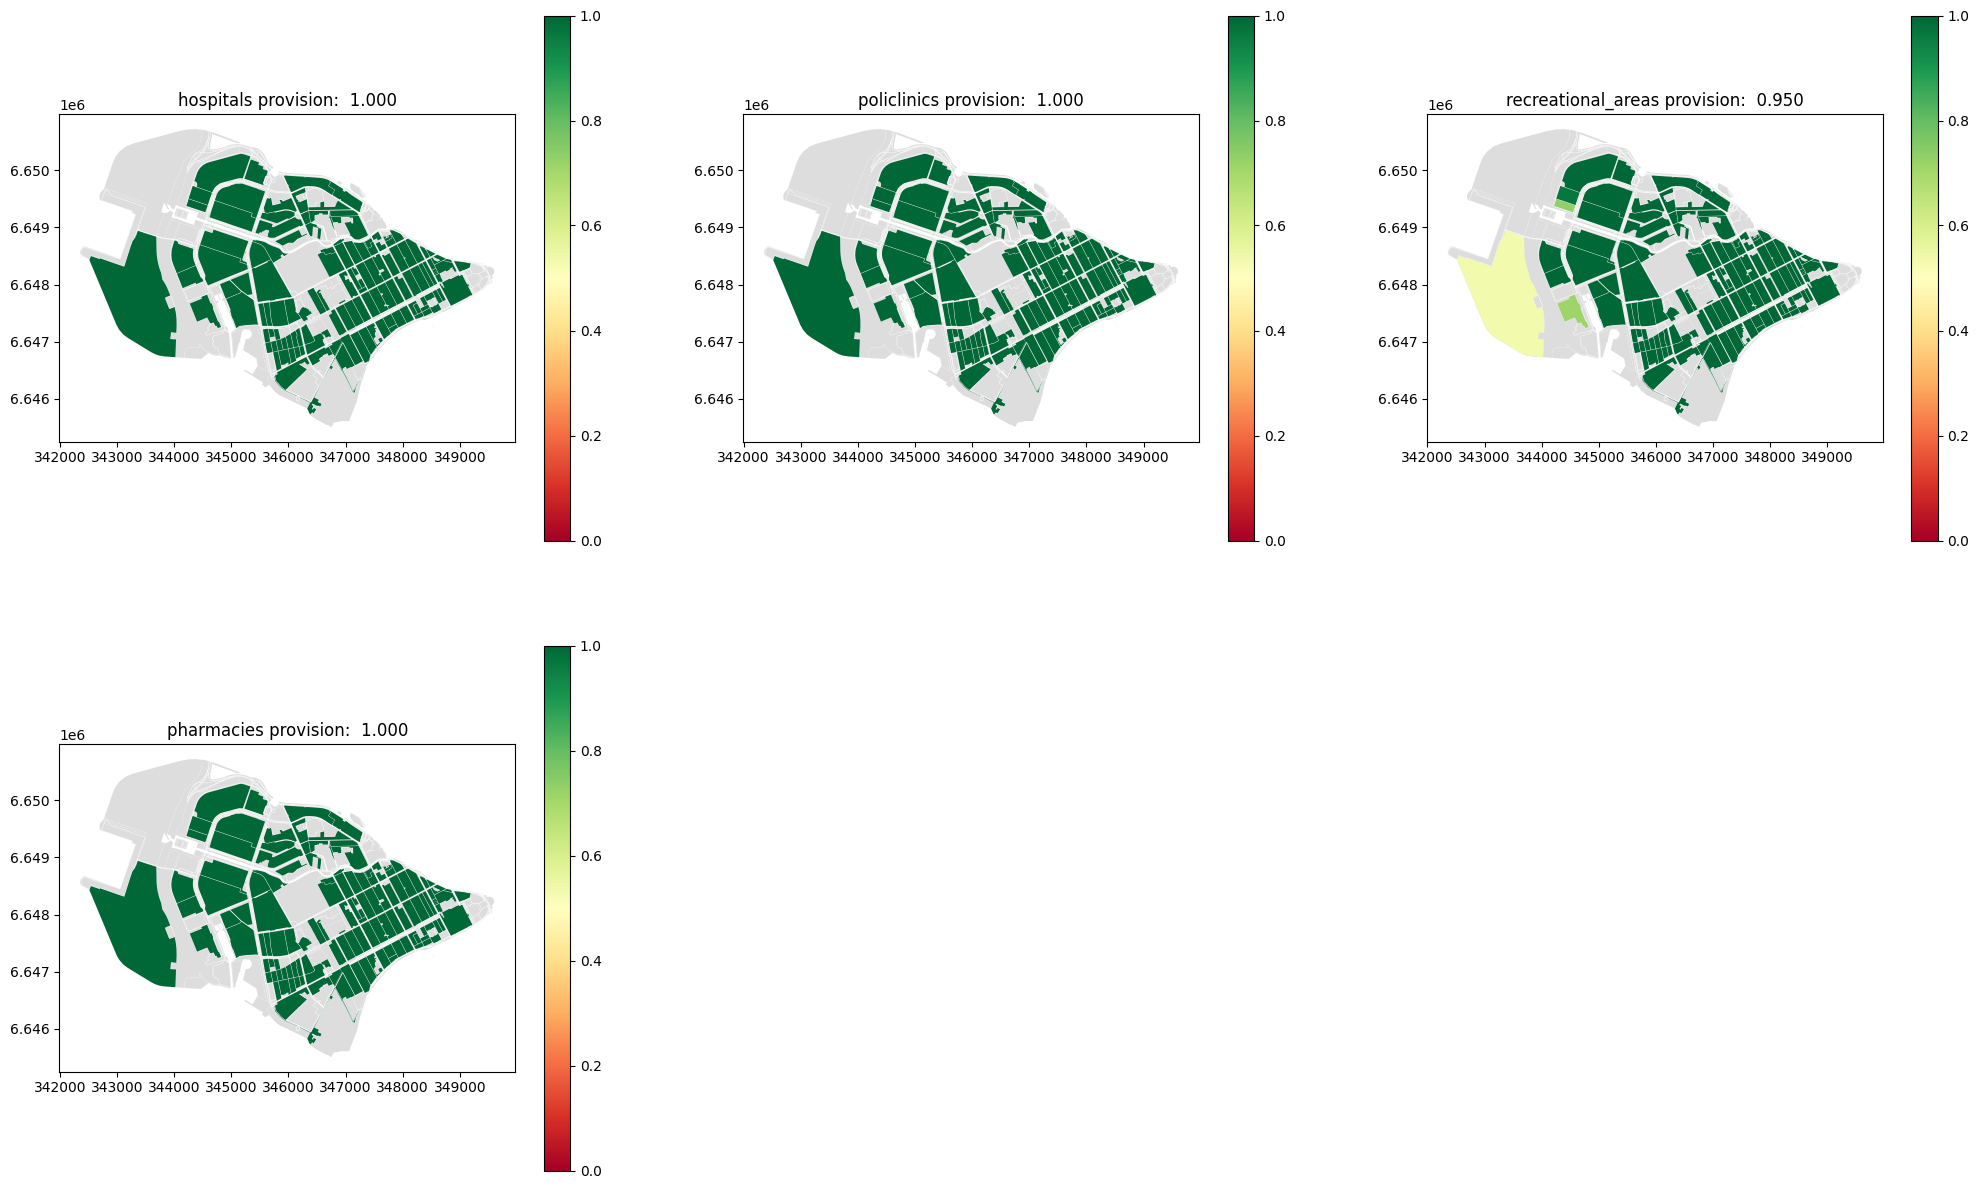

In [16]:
lpp.visualize_provisions(provisions)

In [24]:
pd.DataFrame.from_dict(data=updated_blocks, orient='index').head()

,hospitals,policlinics,recreational_areas,pharmacies
0,0,0,0,500
1,0,0,0,2000
3,0,0,0,500
4,0,0,0,2000
6,0,0,100,0


# Оптимизация выбранных кварталов
Для примера кварталы выбираются случайно

In [25]:
gdf_ = gdf[(gdf['landuse']!='no_dev_area')&(gdf['free_area']>0.5)].sample(30)

<Axes: >

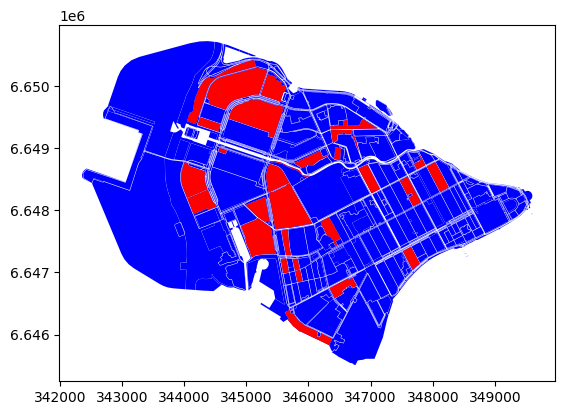

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

gdf.plot(color='blue', ax=ax)
gdf_.plot(color='red', ax=ax)

In [27]:
gen = Genetic(city_model, gdf_, all_services, scenario, 3)
ga_params = {
    'num_generations': 10,
    'num_parents_mating': 6,
    'sol_per_pop': 10,
    'mutation_type': 'adaptive',
    'mutation_percent_genes': (90, 10),
    'crossover_type': 'scattered',
    'parent_selection_type': 'tournament',
    'K_tournament': 3,
    'stop_criteria': 'saturate_50',
    'parallel_processing': 12,
    'keep_parents': 1
}
ga_instance, updated_blocks = gen.calculate_blocks_building_optinons(ga_params)

In [28]:
provisions, mean = lpp.get_scenario_provisions(scenario, updated_blocks)
print('Mean provision:', mean)

Mean provision: 0.9199487656038605


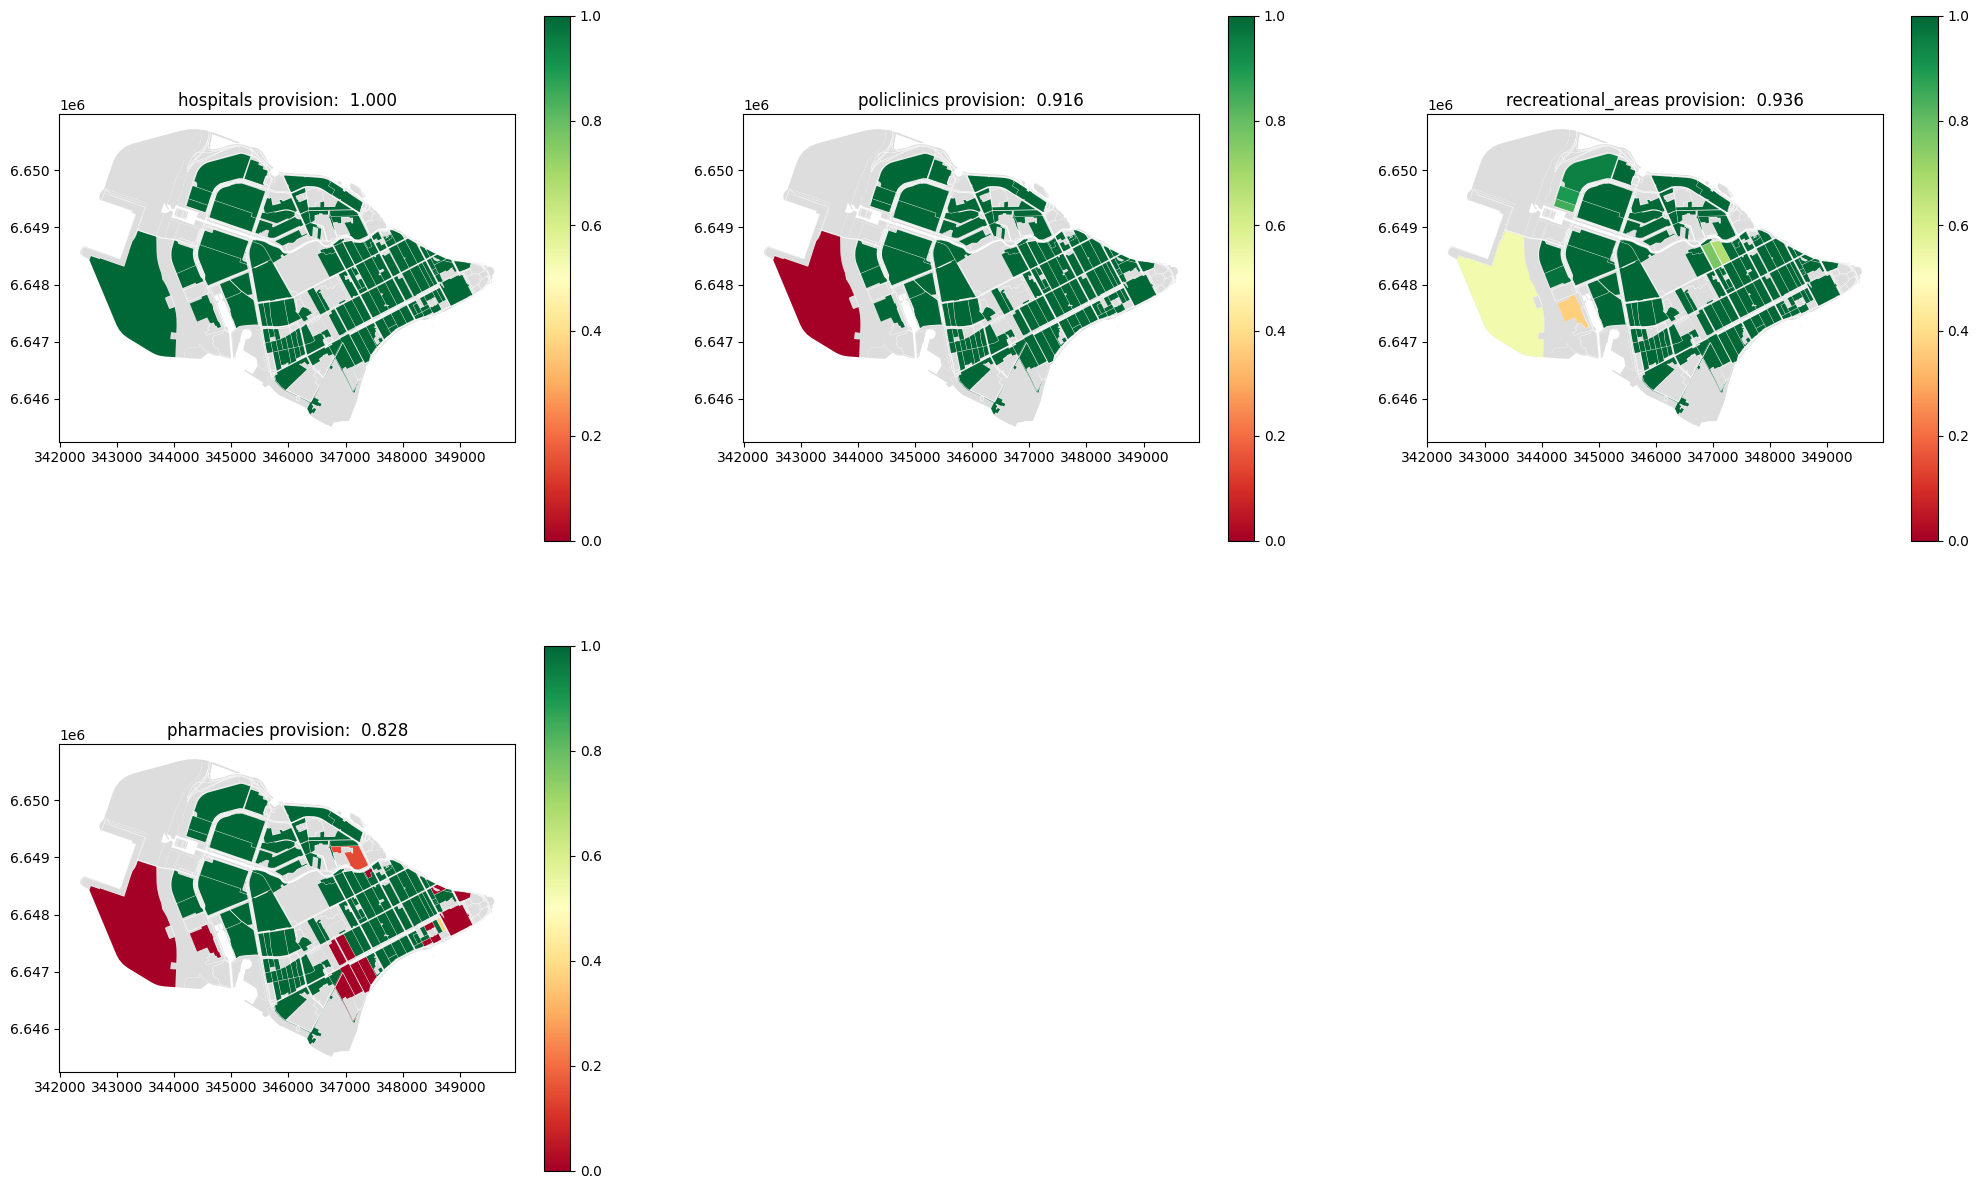

In [29]:
lpp.visualize_provisions(provisions, updated_blocks)

In [30]:
pd.DataFrame.from_dict(data=updated_blocks, orient='index').head()

,hospitals,policlinics,recreational_areas,pharmacies
964,0,0,600,1500
224,0,9615,100,1000
74,0,0,0,2000
53,0,0,100,1500
929,60000,9615,5000,0
